<a href="https://colab.research.google.com/github/fgprevito/building-intuition/blob/main/Ridge_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import libraries

# Download files from my computer
from google.colab import files
# Allows me to manage file related input and output operations
# ex. reading or writing to files
import io

# Pandas provides data structures to let me work with relational or labeled data
# In this case I can transform the google sheet data into a pandas dataframe I can work with
import pandas

# For matrix algebra and other mathematic operations that I'll need to do on
# my dataset, I will import numpy, since it specializes in allowing me to work
# with multi-dimsensional arary objects and providing fucntions/mathematical
# tools for working with these arrays
import numpy

# For visualizing results/data points, I'll use matplotlib, since it
# specializes in creating various types of visualizations
from matplotlib import pyplot

# In order to handle the Ridge regression CV
# sklearn specializes in implementing ML models and statistical
# models like ridge regressions. RidgeCV library which will give me ridge regression functionality with cross validation built in.
# train_test_split will help me split arrays into trainng and testing data sets automatically.
# mean_squared_error is to evaluate MSE, while numpy can cover the rest of the evaluation criteria
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
# make a function that makes a fake "spreadsheet" (as a dataframe)

In [ ]:
# fake spreadsheet in so-called "long" format
# each row will have a company, a sector, a year, and some value (like net operating capital or some shit)

def half_of_fake_spreadsheet(NUM_SECTORS, NUM_COMPANIES_PER_SECTOR, START_YEAR, NUM_YEARS):
  # NUM_SECTORS = 4
  # NUM_COMPANIES_PER_SECTOR = 3
  # START_YEAR = 2017
  # NUM_YEARS = 3

  snames = ['Sector'+str(x) for x in range(NUM_SECTORS)]
  cnames = [['FakeCo'+str(x)+'-'+sector_name for x in range(NUM_COMPANIES_PER_SECTOR)] for sector_name in snames]
  cnames = [item for sublist in cnames for item in sublist]

  rows = []
  for cc in cnames:
    implied_sector = cc.split('-')[1]
    for yy in range(NUM_YEARS):
      rows.append([cc, implied_sector, START_YEAR + yy])

  df = pandas.DataFrame(data=rows, columns=['Company Name', 'Sector', 'Year'])
  return df

In [ ]:
df = half_of_fake_spreadsheet(NUM_SECTORS=4, NUM_COMPANIES_PER_SECTOR=3, START_YEAR=2017, NUM_YEARS=3)
# now I need another kind function to make up fake return values for those company / year combos

In [ ]:
def companies_only_affects(df, NOISE_LEVEL=0):
  company_levels = { x : ii for (ii,x) in enumerate(df['Company Name'].unique()) }
  company_level_values = numpy.random.rand(len(company_levels))
  # company_levels, company_level_values

  plain_company_returns = numpy.array([company_level_values[company_levels[x]] for x in df['Company Name']])
  noisy_company_returns = plain_company_returns + NOISE_LEVEL * numpy.random.randn(plain_company_returns.shape[0])
  df['Return'] = noisy_company_returns
  return df

In [ ]:
def companies_and_sector_affects(df, NOISE_LEVEL=0):
  company_levels = { x : ii for (ii,x) in enumerate(df['Company Name'].unique()) }
  company_level_values = numpy.random.rand(len(company_levels))

  sector_levels = { x : ii for (ii,x) in enumerate(df['Sector'].unique()) }
  sector_level_values = numpy.random.rand(len(sector_levels))

  plain_company_returns = numpy.array([company_level_values[company_levels[x]] for x in df['Company Name']])
  plain_sector_returns = numpy.array([sector_level_values[sector_levels[x]] for x in df['Sector']])

  noisy_returns = plain_company_returns + plain_sector_returns + NOISE_LEVEL * numpy.random.randn(plain_company_returns.shape[0])
  df['Return'] = noisy_returns
  return df



---

Company+Sector+Year affects outcome

---



In [ ]:
fake_spreadsheet = companies_and_sector_affects(df, NOISE_LEVEL=0)

In [ ]:
the_spreadsheet = fake_spreadsheet

In [ ]:
def extract_company_design(the_spreadsheet):
  unique_companies = { x : ii for (ii,x) in enumerate(the_spreadsheet['Company Name'].unique()) }

  num_unique_companies = len(unique_companies)

  design = numpy.zeros((the_spreadsheet.shape[0], num_unique_companies))
  for ii, cn in enumerate(the_spreadsheet['Company Name']):
    design[ii, unique_companies[cn]] = 1

  return design




---


A design matrix is nothing but a landscape for me to record which factors affect which outcomes


---


In [ ]:

unique_companies = { x : ii for (ii,x) in enumerate(the_spreadsheet['Company Name'].unique()) }

num_unique_companies = len(unique_companies)

design = numpy.zeros((the_spreadsheet.shape[0], num_unique_companies))
for ii, cn in enumerate(the_spreadsheet['Company Name']):
  design[ii, unique_companies[cn]] = 1


In [ ]:
print(the_spreadsheet)

       Company Name   Sector  Year    Return
0   FakeCo0-Sector0  Sector0  2017  1.520840
1   FakeCo0-Sector0  Sector0  2018  1.520840
2   FakeCo0-Sector0  Sector0  2019  1.520840
3   FakeCo1-Sector0  Sector0  2017  1.226209
4   FakeCo1-Sector0  Sector0  2018  1.226209
5   FakeCo1-Sector0  Sector0  2019  1.226209
6   FakeCo2-Sector0  Sector0  2017  1.332911
7   FakeCo2-Sector0  Sector0  2018  1.332911
8   FakeCo2-Sector0  Sector0  2019  1.332911
9   FakeCo0-Sector1  Sector1  2017  1.099962
10  FakeCo0-Sector1  Sector1  2018  1.099962
11  FakeCo0-Sector1  Sector1  2019  1.099962
12  FakeCo1-Sector1  Sector1  2017  0.948198
13  FakeCo1-Sector1  Sector1  2018  0.948198
14  FakeCo1-Sector1  Sector1  2019  0.948198
15  FakeCo2-Sector1  Sector1  2017  1.066992
16  FakeCo2-Sector1  Sector1  2018  1.066992
17  FakeCo2-Sector1  Sector1  2019  1.066992
18  FakeCo0-Sector2  Sector2  2017  0.944305
19  FakeCo0-Sector2  Sector2  2018  0.944305
20  FakeCo0-Sector2  Sector2  2019  0.944305
21  FakeCo

In [ ]:
# make a function that takes a dataframe -> makes a design matrix

In [ ]:
NOISE = 0
SINGLE_CO_NOISE = 1
START_YEAR = 2017
NUM_YEARS = 2



---

This next section I now generate the fake data.

I need my companies to be associated to their respective sectors. I'm going to continue using the same method I've used to generate fake data which is to manually write it up inside of a list, generate a data dictionary for each list so that each value has a respective numeric representation, and then pass these numeric representations of my company, sector, year data into a set of arrays that I will combine to form a design matrix.

The reason for this is I believe it'll be easier for me to modify the data if I would like to versus loading in a dataframe from google sheets.

---





---

I have a list of companies alongside the sector they belong to. I want to be able to pass all this data in numeric form into a design matrix so that I can mathematically analyze it.

---



In [ ]:
# Creating a list of companies along with the sectors they belong to

company_data = [('Apple', 'Tech'),('Microsoft', 'Tech'),('Amazon', 'Tech'),('Dell', 'Tech'),('Novartis', 'Pharma'),('Merck', 'Pharma'),('Alcon', 'Pharma'),('Abbvie', 'Pharma')]
company_data

[('Apple', 'Tech'),
 ('Microsoft', 'Tech'),
 ('Amazon', 'Tech'),
 ('Dell', 'Tech'),
 ('Novartis', 'Pharma'),
 ('Merck', 'Pharma'),
 ('Alcon', 'Pharma'),
 ('Abbvie', 'Pharma')]

In [ ]:
# List comprehension: expression for element in iterable if condition
# enumerate(company_data) for elements in company_data, enumerate each value
# for ii,x in enumerate(company_data) then iterate through both the value and index pairs
# {x:ii for ii,x in enumerate(company_data)} and the expression is creating a dictionary where they key is x and value is ii

# AKA This is the expression i want performed for these iterable values in the element enumerate(company_data)

company_map = {x: ii for ii,x in enumerate(company_data)}
company_map

{('Apple', 'Tech'): 0,
 ('Microsoft', 'Tech'): 1,
 ('Amazon', 'Tech'): 2,
 ('Dell', 'Tech'): 3,
 ('Novartis', 'Pharma'): 4,
 ('Merck', 'Pharma'): 5,
 ('Alcon', 'Pharma'): 6,
 ('Abbvie', 'Pharma'): 7}

In [ ]:
# Ditto

year_data = numpy.arange(START_YEAR, START_YEAR + NUM_YEARS)
year_map = {x:ii for ii,x in enumerate(year_data)}
year_map

{2017: 0, 2018: 1}



---

Now that I have generated a set of fictitious data and married them to numeric values, I can create my design matrix. The method I will be using to create my design matrix is I can pass the numeric representatiosn of my fictitious data into a set of arrays that I can stack into a design matrix.

Why am I building a design matrix?

The design matrix is essentially a diagram that allows me to explain the outputs in terms of the inputs. so for each row I'll have a certain company, the sector it's in, and the year in which I am looking at this company and sector, and I can then chart this data directly to an output. Its basically the most simple way I can explain my outputs as a result of my inputs. Through this design matrix though, I'll be able to perform some more sophisticated analysis which I'll get to in a second.

---

So that's the theoretical/verbal description of how I will accomplish the creation of my design matrix but programmatically how can I accomplish this goal?




---


In [ ]:
# creating an accumulator. The results from the following for loop logic will
# be accumulated in this list before stacking them into a matrix format

# for each year within the range selected through the constants START_YEAR and NUM_YEARS
  # iterate through each row within company_map
      # for each row in company_map create a row of zeros the length of the lists company_data and year_data
      # we will use these rows of 0s as plceholders to store values

      # for the iteration we are on, select that 0 and set it = 1
      # ex. where c = 1, find the value at company_map = 1 and set that 0 in new_row to 1

      # for the year iteration we are on, set that 0 = 1
      # ex if yy = 1, find the value at year_map = 1 and set the corresponding space in
      # new_row to 1 after passing a number of 0s equal to the length of company_data
      # so if company_data has length of 8, first skip through 8 zeros, then begin selecting values for year

      # append this new_row to the list acc

# vertically concatonates the list of arrays stored in acc to form the
# design matrix

acc = []

for yy in range(START_YEAR, START_YEAR + NUM_YEARS):
    for c in company_map:
      new_row = numpy.zeros(len(company_data) + len(year_data), )
      new_row[company_map[c]] = 1
      new_row[year_map[yy] + len(company_data)] = 1
      acc.append(new_row)

design_matrix = numpy.vstack(acc)
design_matrix

array([[1., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 1.]])

In [ ]:
acc = []

for yy in range(START_YEAR, START_YEAR + NUM_YEARS):
  for c in company_data:
    new_row = numpy.zeros(len(company_data) + len(year_data), )
    new_row[company_map[c]] = 1
    new_row[year_map[yy] + len(company_data)] = 1
    acc.append(new_row)

design_matrix = numpy.vstack(acc)
design_matrix

array([[1., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 1.]])



---

First step in solving a problem is getting a lay of the land, figuring out what info I have at my disposal so that I can most effectively solve my problem of understanding the relationships between variables and predicting future observations. I know I'll be using matrix algebra to manipulate and analyze data so it's important I know the dimensions of my design matrix

---



In [ ]:
# identifying the shape of the deisgn matrix

design_matrix.shape

(16, 10)



---

now I want know the rank of my matrix. This will give me an early check as to whether or not I have covariant data (essentially columns that may not necessarily be relevant to predicting stock price)

---



In [ ]:
# calculating my deisng matrix' rank

numpy.linalg.matrix_rank(design_matrix)

9



---

I can see it is rank deficient. When I worked with only 1 variable my matrix was full rank, but when I added a second variable my matrix rank was = n columns - 1. Now I have 3 variables and the matrix rank is = n columns - 2.

Why is that?

Rank deficiency effectively means I have insufficient information in my data to be able to estimate the model I desire.


---



In [ ]:
# Creating the true relationship between variables I am trying to identify using
# ridge regression cross validated

actual_weights = numpy.random.rand(design_matrix.shape[1])
actual_weights

array([0.32822263, 0.86632878, 0.36618995, 0.5127965 , 0.75765971,
       0.35799573, 0.81704415, 0.93709266, 0.63518225, 0.56872395])

In [ ]:
# Generating fictitious continuous financial output based on inputs times their
# weights

outcomes = numpy.dot(design_matrix, actual_weights)
outcomes

array([0.96340488, 1.50151103, 1.00137221, 1.14797875, 1.39284196,
       0.99317799, 1.4522264 , 1.57227492, 0.89694658, 1.43505273,
       0.93491391, 1.08152045, 1.32638366, 0.92671969, 1.3857681 ,
       1.50581662])

In [ ]:
# Adding noise to the outcomes

outcomes += (numpy.random.rand(outcomes.shape[0]) - .5) * NOISE
outcomes

array([0.96340488, 1.50151103, 1.00137221, 1.14797875, 1.39284196,
       0.99317799, 1.4522264 , 1.57227492, 0.89694658, 1.43505273,
       0.93491391, 1.08152045, 1.32638366, 0.92671969, 1.3857681 ,
       1.50581662])

In [ ]:
# adding noise to a single outcome observation to simulate outliers

outcomes[0] = outcomes[0] * SINGLE_CO_NOISE
outcomes

array([0.96340488, 1.50151103, 1.00137221, 1.14797875, 1.39284196,
       0.99317799, 1.4522264 , 1.57227492, 0.89694658, 1.43505273,
       0.93491391, 1.08152045, 1.32638366, 0.92671969, 1.3857681 ,
       1.50581662])

In [ ]:
# Covariance

numpy.dot(design_matrix.T, design_matrix)

array([[2., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 2., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 2., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 2., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 2., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 2., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 2., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 2., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 8., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 0., 8.]])

In [ ]:
# Precision

numpy.linalg.pinv(numpy.dot(design_matrix.T, design_matrix))

array([[ 0.44  , -0.06  , -0.06  , -0.06  , -0.06  , -0.06  , -0.06  ,
        -0.06  ,  0.01  ,  0.01  ],
       [-0.06  ,  0.44  , -0.06  , -0.06  , -0.06  , -0.06  , -0.06  ,
        -0.06  ,  0.01  ,  0.01  ],
       [-0.06  , -0.06  ,  0.44  , -0.06  , -0.06  , -0.06  , -0.06  ,
        -0.06  ,  0.01  ,  0.01  ],
       [-0.06  , -0.06  , -0.06  ,  0.44  , -0.06  , -0.06  , -0.06  ,
        -0.06  ,  0.01  ,  0.01  ],
       [-0.06  , -0.06  , -0.06  , -0.06  ,  0.44  , -0.06  , -0.06  ,
        -0.06  ,  0.01  ,  0.01  ],
       [-0.06  , -0.06  , -0.06  , -0.06  , -0.06  ,  0.44  , -0.06  ,
        -0.06  ,  0.01  ,  0.01  ],
       [-0.06  , -0.06  , -0.06  , -0.06  , -0.06  , -0.06  ,  0.44  ,
        -0.06  ,  0.01  ,  0.01  ],
       [-0.06  , -0.06  , -0.06  , -0.06  , -0.06  , -0.06  , -0.06  ,
         0.44  ,  0.01  ,  0.01  ],
       [ 0.01  ,  0.01  ,  0.01  ,  0.01  ,  0.01  ,  0.01  ,  0.01  ,
         0.01  ,  0.1025, -0.0225],
       [ 0.01  ,  0.01  ,  0.01  ,  0

In [ ]:
# Hat

numpy.dot(numpy.linalg.pinv(numpy.dot(design_matrix.T, design_matrix)), design_matrix.T)

array([[ 0.45  , -0.05  , -0.05  , -0.05  , -0.05  , -0.05  , -0.05  ,
        -0.05  ,  0.45  , -0.05  , -0.05  , -0.05  , -0.05  , -0.05  ,
        -0.05  , -0.05  ],
       [-0.05  ,  0.45  , -0.05  , -0.05  , -0.05  , -0.05  , -0.05  ,
        -0.05  , -0.05  ,  0.45  , -0.05  , -0.05  , -0.05  , -0.05  ,
        -0.05  , -0.05  ],
       [-0.05  , -0.05  ,  0.45  , -0.05  , -0.05  , -0.05  , -0.05  ,
        -0.05  , -0.05  , -0.05  ,  0.45  , -0.05  , -0.05  , -0.05  ,
        -0.05  , -0.05  ],
       [-0.05  , -0.05  , -0.05  ,  0.45  , -0.05  , -0.05  , -0.05  ,
        -0.05  , -0.05  , -0.05  , -0.05  ,  0.45  , -0.05  , -0.05  ,
        -0.05  , -0.05  ],
       [-0.05  , -0.05  , -0.05  , -0.05  ,  0.45  , -0.05  , -0.05  ,
        -0.05  , -0.05  , -0.05  , -0.05  , -0.05  ,  0.45  , -0.05  ,
        -0.05  , -0.05  ],
       [-0.05  , -0.05  , -0.05  , -0.05  , -0.05  ,  0.45  , -0.05  ,
        -0.05  , -0.05  , -0.05  , -0.05  , -0.05  , -0.05  ,  0.45  ,
        -0.05



---

Because I know I'm trying to predict some kind of continuous variable, this is the reason I have selected a regression model. The purpose for selecting a ridge regression model in particular is because it has the particular capability of being able to simplify complex relationships as something linear, improving my ability to interpret the relationships between my variables, while still retaining decently strong predictability.  

---



In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(design_matrix, outcomes, test_size=.3)

# This is for special case for ridge regression
X_train = design_matrix[1:]
y_train = outcomes[1:]
X_test = design_matrix[:1]
y_test = outcomes[:1]

ridge = RidgeCV(alphas=[.01, .1, 1.0, 10.0, 100.0], fit_intercept=False)
ridge.fit(X_train, y_train)
ridge.coef_

array([-0.04433781,  0.49088631, -0.00676427,  0.1391129 ,  0.38275788,
       -0.01491772,  0.44184687,  0.56129813,  1.00815452,  0.94172777])

In [ ]:
pred_outcomes = ridge.predict(X_test)
pred_outcomes

array([0.9638167])

Text(0, 0.5, 'Predicted Weights')

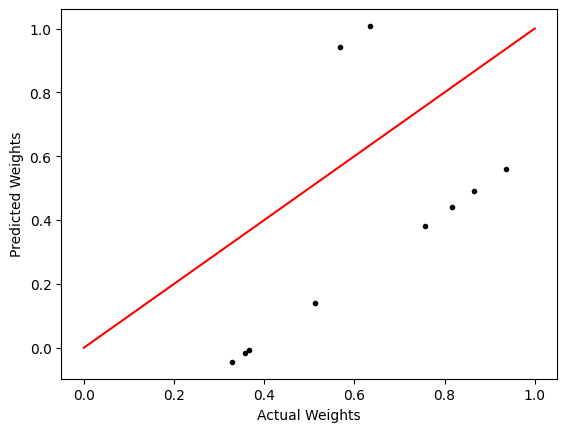

In [ ]:
pyplot.plot([0,1], [0,1], 'r-')
pyplot.plot(actual_weights, ridge.coef_, 'k.')

pyplot.xlabel('Actual Weights')
pyplot.ylabel('Predicted Weights')

Text(0, 0.5, 'Pred Outcomes')

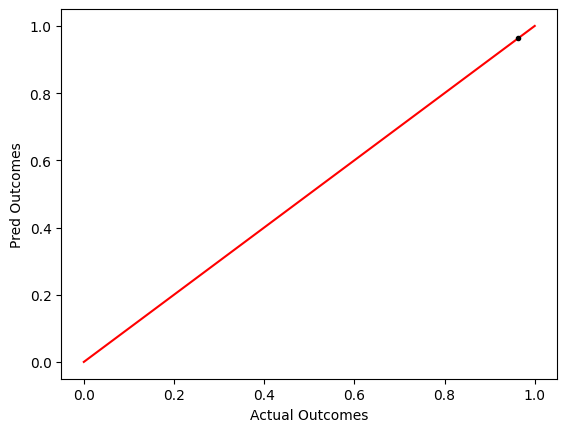

In [ ]:
pyplot.plot([0,1], [0,1], 'r-')
pyplot.plot(y_test, pred_outcomes, 'k.')

pyplot.xlabel('Actual Outcomes')
pyplot.ylabel('Pred Outcomes')

In [ ]:
# MSE

numpy.mean((pred_outcomes - y_test)**2)

1.695977777353839e-07

In [ ]:
# ME

numpy.mean(actual_weights - ridge.coef_)

0.22474717416285053

In [ ]:
# Variance

numpy.var(actual_weights - ridge.coef_)

0.08932301993378775

In [ ]:
# Standard Deviation

numpy.std(actual_weights - ridge.coef_)

0.2988695701033943



---


Observations:

When only adding noise to a single variable, Ridge does great job at identifying the true regression weights and not allowing the noisy variable to skew calculations.

MSE seems to be worse at times? It could be because I'm effectively overfitting the OLS to the training data, so what I'm observing is the overfit model working better on the dataset I trained it on. Ridge should in theory be better able to predict future values as it's supposed to be better about not letting noisy variables affect it's ability to calculate the parameters.

When I add a noisy variable to training data and set test data to be without noise, the difference was highlighted. Could see how OLS MSE was worse while Ridge kept its form.


---


We're still assuming that the relationship is linear, but Ridge is supposed to work better even if outcome is discrete or relationship between inputs and outputs is logarithmic. This leads me to believe regardless of the relationship Ridge shoud do at least a decent job at calculating parameters and predicting future observations.

Shouldn't direclty inteerpret params as true relationshio due to lambda and model is less interpretable since ridge retains irrelevant columns.

Can I still use Ridge to understand the relationship between data? Or is it mroe an answer to the fact that we can perfectly model the compelxity of the world so we created a hack to simplify the complexity?


---
